# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик этого исследования — сеть отелей «Как в гостях».

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

**Бизнес-метрика и другие данные**

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

 Стоимость номеров отеля:

•	категория A: за ночь — 1 000, разовое обслуживание — 400;

•	категория B: за ночь — 800, разовое обслуживание — 350;

•	категория C: за ночь — 600, разовое обслуживание — 350;

•	категория D: за ночь — 550, разовое обслуживание — 150;

•	категория E: за ночь — 500, разовое обслуживание — 150;

•	категория F: за ночь — 450, разовое обслуживание — 150;

•	категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

### Шаг 1. Откройте файлы с данными

In [136]:
#блок загрузки библиотек
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from sklearn.tree import DecisionTreeClassifier      # классификатор дерева решений
from sklearn.ensemble import RandomForestClassifier  # классификатор случайного леса
from sklearn.linear_model import LogisticRegression  # логистическая регрессия
from sklearn.preprocessing import StandardScaler     # функция для стандартизации данных
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, roc_curve

In [137]:
#блок загрузки датасета
df1 = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_train.csv')
df2 = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_test.csv')

#изначально обрежем значения до 3 знака после запятой при воспроизведении
pd.set_option('display.float_format', lambda x: '%.3f' % x)
#для удобства отображения таблиц
pd.options.display.max_columns = 100 

<div class="alert alert-info" style="border-color: pink; border-radius: 5px">
    <p><u><b> ВЫВОДЫ ПО РАЗДЕЛУ 1</b></u></p>
    <p>Всё открывается и это очень хорошо</p>
</div>

### Шаг 2. Предобработка и исследовательский анализ данных

In [138]:
#функция для первичного ознакомления с датафреймами
def df_info(name_dataset):
    print('Посмотрим на первые 5 строк в датафрейме')
    print('')
    display(name_dataset.head(5))          
    print('')
    print('Изучим тип данных')
    print('')
    print(name_dataset.info())
    print('')
    print('Размерность DataFrame (строки, столбцы) ', name_dataset.shape)
    print('')
    print('Изучим общие статистические данные данных в датафрейме')
    print('')
    display (name_dataset.describe().transpose())        
    print('')
    print('Проверим датафрейм на пропуски')
    print (name_dataset.isna().sum())
    print('')
    print ('Проверим датафрейм на дубликаты')
    print (name_dataset.duplicated().sum())
    print('')
    numeric_columns = name_dataset.select_dtypes(include=[np.number]) # Выбор только числовых столбцов
    plt.figure(figsize=(20, 12))
    plt.title('Корреляция признаков')
    sns.heatmap(numeric_columns.corr(method='spearman'), annot=True, cmap="coolwarm")
    plt.show()

Посмотрим на первые 5 строк в датафрейме



,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.000,2015,July,27,1,0,1,1.000,0.000,0.000,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.000,2015,July,27,1,0,2,2.000,0.000,0.000,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.000,2015,July,27,1,0,2,2.000,0.000,0.000,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.000,2015,July,27,1,0,2,2.000,0.000,0.000,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.000,2015,July,27,1,0,3,2.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3



Изучим тип данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal        

,count,mean,std,min,25%,50%,75%,max
id,65229.000,43544.069,25614.859,0.000,19108.000,40554.000,67414.000,84121.000
is_canceled,65229.000,0.369,0.482,0.000,0.000,0.000,1.000,1.000
lead_time,65229.000,96.338,96.128,0.000,17.000,64.000,151.000,374.000
arrival_date_year,65229.000,2015.719,0.449,2015.000,2015.000,2016.000,2016.000,2016.000
arrival_date_week_number,65229.000,31.340,13.464,1.000,21.000,34.000,42.000,53.000
arrival_date_day_of_month,65229.000,15.848,8.748,1.000,8.000,16.000,23.000,31.000
stays_in_weekend_nights,65229.000,0.825,0.853,0.000,0.000,1.000,2.000,4.000
stays_in_week_nights,65229.000,2.225,1.355,0.000,1.000,2.000,3.000,6.000
adults,65229.000,1.837,0.480,0.000,2.000,2.000,2.000,4.000
children,65229.000,0.075,0.334,0.000,0.000,0.000,0.000,3.000



Проверим датафрейм на пропуски
id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

Проверим датафрейм на дубликаты
0



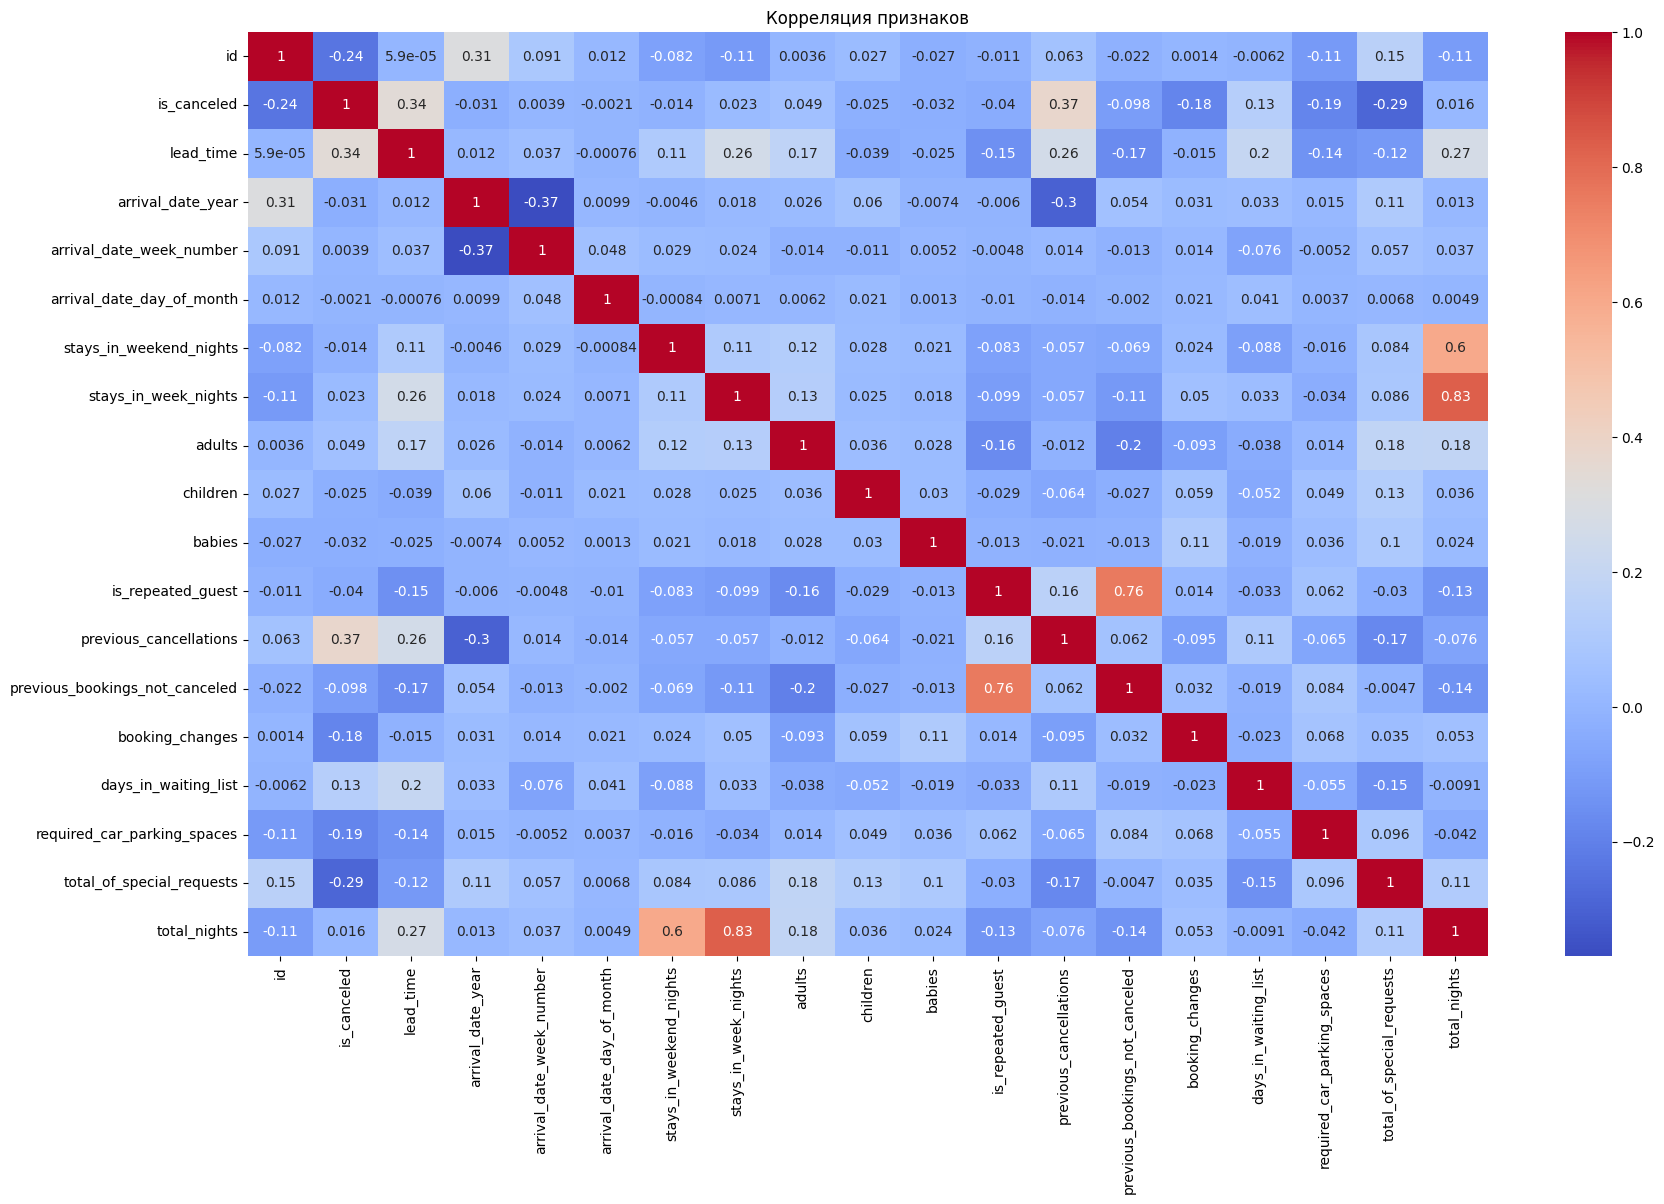

In [139]:
#Изучим данные по первому датафрейму
df_info(df1)

**ПЕРВЫЕ ВЫОДЫ по df1**

На первый взгляд достаточно чистые данные. Данные за 2015-2016 года. Пропусков нет. Явных дубликатов нет. Ожидаемо наиболее выраженная взаимосвзязь между столбцами stays_in_weekend_nights "количество ночей в выходные дни" и total_nights "общее количество ночей" - 0.6, а также stays_in_week_nights "количество ночей в будние дни" и total_nights "общее количество ночей" - 0.83. Так же is_repeated_guest — "признак того, что гость бронирует номер второй раз" и previous_bookings_not_canceled — "количество подтверждённых заказов у клиента большая взаимосвязь" - 0.76. В babies "количество младенцев" странное значение - 10. Эти значения previous_cancellations,	previous_bookings_not_canceled,	booking_changes	days_in_waiting_list тоже надо посмотреть внимательней. Так же необходимо посмотреть категориальные значения: meal,	country, distribution_channel, reserved_room_type, customer_type. 

Посмотрим на первые 5 строк в датафрейме



,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.000,2017,January,1,1,1,0,2.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.000,2017,January,1,1,2,2,2.000,0.000,0.000,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.000,2017,January,1,1,2,2,2.000,0.000,0.000,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.000,2017,January,1,1,2,2,1.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.000,2017,January,1,1,2,5,2.000,0.000,0.000,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7



Изучим тип данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal        

,count,mean,std,min,25%,50%,75%,max
id,32412.000,60131.505,29953.586,6086.000,45291.750,53394.500,89800.250,97903.000
is_canceled,32412.000,0.388,0.487,0.000,0.000,0.000,1.000,1.000
lead_time,32412.000,97.588,86.507,0.000,23.000,76.000,155.000,373.000
arrival_date_year,32412.000,2017.000,0.000,2017.000,2017.000,2017.000,2017.000,2017.000
arrival_date_week_number,32412.000,17.804,9.177,1.000,10.000,18.000,25.000,35.000
arrival_date_day_of_month,32412.000,15.657,8.766,1.000,8.000,15.500,23.000,31.000
stays_in_weekend_nights,32412.000,0.868,0.853,0.000,0.000,1.000,2.000,4.000
stays_in_week_nights,32412.000,2.340,1.375,0.000,1.000,2.000,3.000,6.000
adults,32412.000,1.859,0.489,0.000,2.000,2.000,2.000,4.000
children,32412.000,0.084,0.343,0.000,0.000,0.000,0.000,3.000



Проверим датафрейм на пропуски
id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

Проверим датафрейм на дубликаты
0



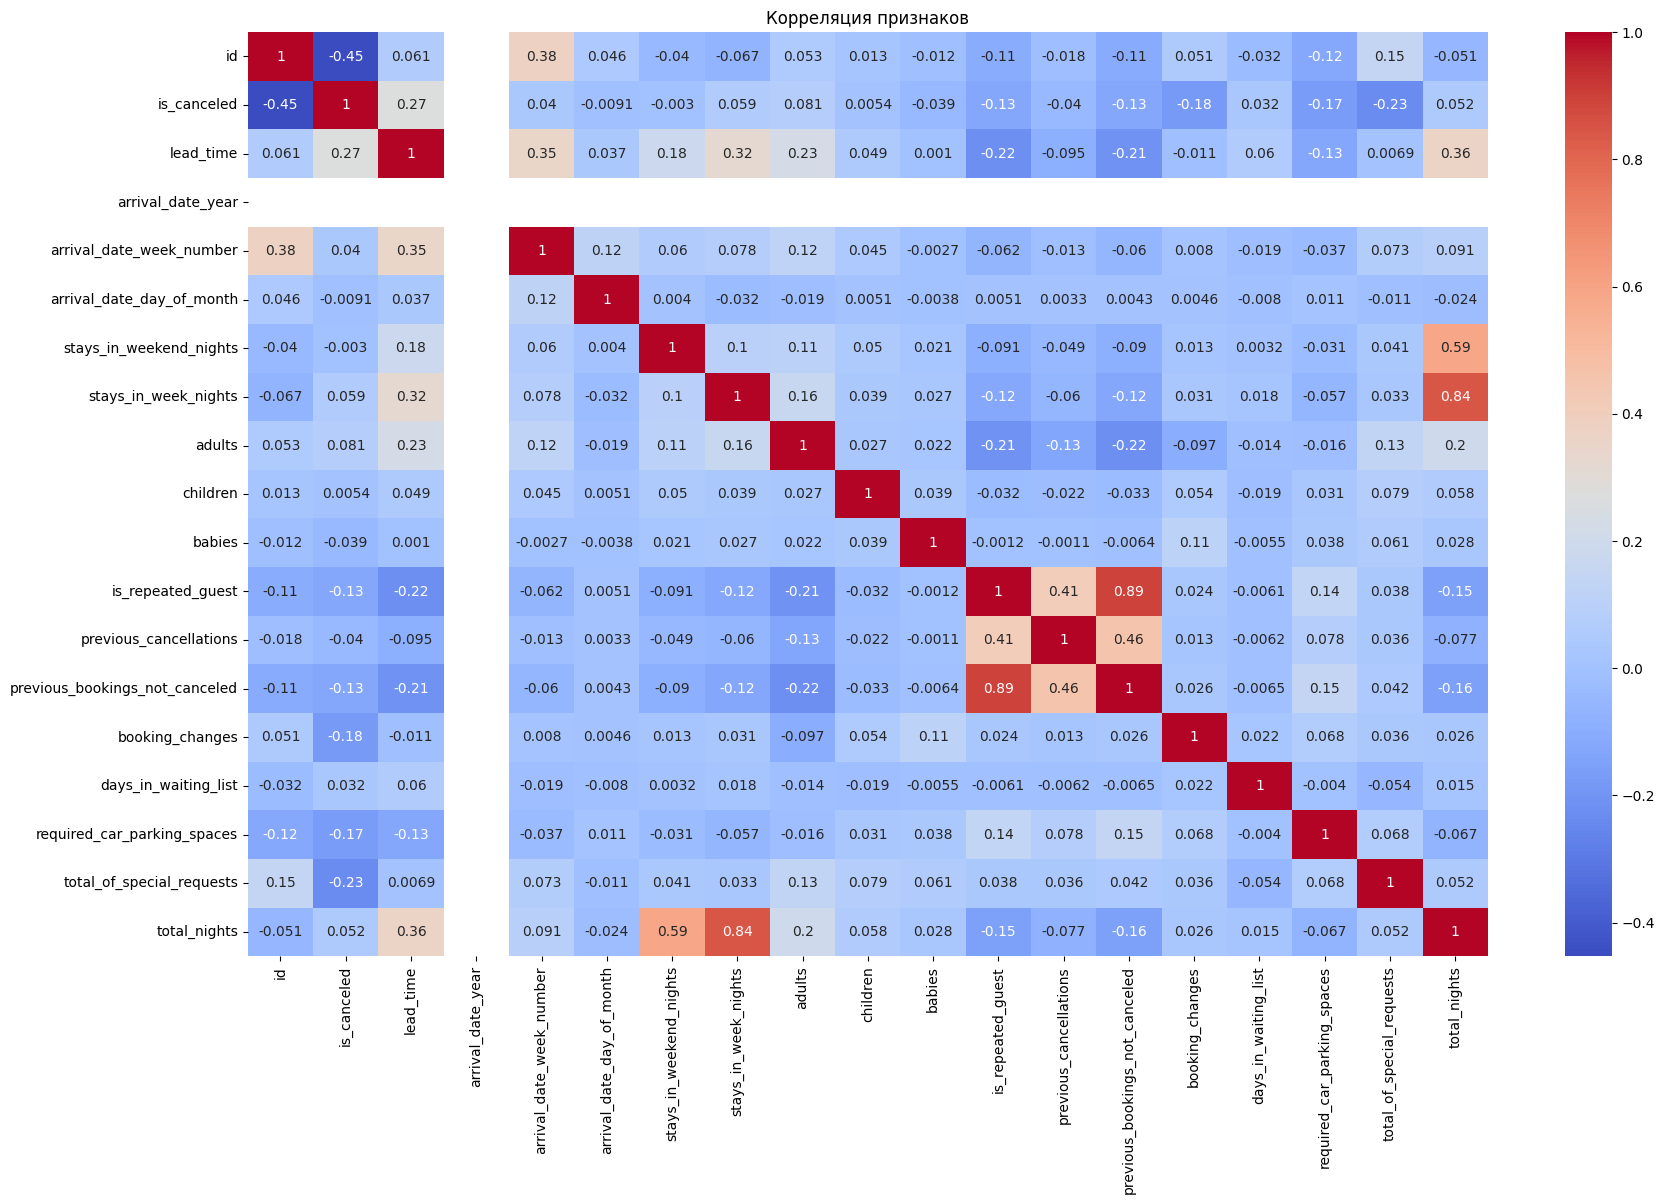

In [140]:
#Изучим данные по второму датафрейму
df_info(df2)

**ПЕРВЫЕ ВЫОДЫ по df2**

Данные за 2017 год. Пропусков нет. Явных дубликатов нет. Ожидаемо наиболее выраженная взаимосвзязь между столбцами stays_in_weekend_nights "количество ночей в выходные дни" и total_nights "общее количество ночей" - 0.59, а также stays_in_week_nights "количество ночей в будние дни" и total_nights "общее количество ночей" - 0.84. Так же is_repeated_guest — "признак того, что гость бронирует номер второй раз" и previous_bookings_not_canceled — "количество подтверждённых заказов у клиента большая взаимосвязь" - 0.86. Эти значения previous_cancellations,	previous_bookings_not_canceled,	booking_changes	days_in_waiting_list тоже надо посмотреть внимательней. Так же необходимо посмотреть категориальные значения: meal,	country, distribution_channel, reserved_room_type, customer_type.

Дальше я буду изучать смежные данные в df1 и df2. (Долго и нудно, но что поделать) Сразу скажу, что так как данные везде разные, к их анализу подхожу везде по разному.

***Проверим adults — количество взрослых постояльцев***

In [141]:
print(df1['adults'].unique())
print(df2['adults'].unique())

[1. 2. 3. 4. 0.]
[2. 1. 3. 4. 0.]


In [142]:
print(df1['adults'].value_counts())
print(df2['adults'].value_counts())

adults
2.000    48980
1.000    13212
3.000     2858
0.000      166
4.000       13
Name: count, dtype: int64
adults
2.000    24237
1.000     6280
3.000     1817
0.000       69
4.000        9
Name: count, dtype: int64


Не понимаю что такое "0" взрослых. Удаляем.

In [143]:
df1 = df1.query('adults!=0')
df2 = df2.query('adults!=0')

In [144]:
# проверяем
print(df1['adults'].unique())
print(df2['adults'].unique())

[1. 2. 3. 4.]
[2. 1. 3. 4.]


**Все в норме.**

***Проверим arrival_date_year — год заезда***

In [145]:
print(df1['arrival_date_year'].unique())
print(df2['arrival_date_year'].unique())

[2015 2016]
[2017]


In [146]:
print(df1['arrival_date_year'].value_counts())
print(df2['arrival_date_year'].value_counts())

arrival_date_year
2016    46748
2015    18315
Name: count, dtype: int64
arrival_date_year
2017    32343
Name: count, dtype: int64


**Все в норме.**

***Проверим arrival_date_month — месяц заезда***

In [147]:
print(df1['arrival_date_month'].unique())
print(df2['arrival_date_month'].unique())

['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']


**В целом все в норме.** Смесь за два года не интерпритируема

***Проверим arrival_date_week_number - неделя заезда***

In [148]:
print(df1['arrival_date_week_number'].unique())
print(df2['arrival_date_week_number'].unique())

[27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25 26]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35]


**В целом все в норме.** Смесь за два года не интерпритируема

***Проверим arrival_date_day_of_month — день заезда***

In [149]:
print(df1['arrival_date_day_of_month'].unique())
print(df2['arrival_date_day_of_month'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
[ 1  2  3  4  5  6  7  8  9 11 12 13 14 16 17 19 20 21 22 23 24 25 26 27
 28 29 30 31 10 15 18]


**В целом все в норме.**

***Проверим babies - количество младенцев***

In [150]:
print (df1['babies'].unique())
print (df2['babies'].unique())

[ 0.  1.  2. 10.  9.]
[0. 1. 2.]


In [151]:
print (df1['babies'].value_counts())
print (df2['babies'].value_counts())

babies
0.000     64614
1.000       444
2.000         3
10.000        1
9.000         1
Name: count, dtype: int64
babies
0.000    32168
1.000      171
2.000        4
Name: count, dtype: int64


**Не корректные данные! Удалим данные 9 и 10**

In [152]:
df1 = df1.query('babies < 9')

In [153]:
# проверим
print (df1['babies'].unique())
print (df2['babies'].unique())

[0. 1. 2.]
[0. 1. 2.]


In [154]:
print (df1['babies'].value_counts())
print (df2['babies'].value_counts())

babies
0.000    64614
1.000      444
2.000        3
Name: count, dtype: int64
babies
0.000    32168
1.000      171
2.000        4
Name: count, dtype: int64


**Все в норме.** Ситуация по данным видимо такая: 0 - это без детей. По сути это пустые данные. Но принимаю решение их не удалять. Чаще всего только с 1 (одним) младенцем.  

In [155]:
df1 = df1.query('babies < 2')
df2 = df2.query('babies < 2')

In [156]:
print (df1['babies'].value_counts())
print (df2['babies'].value_counts())

babies
0.000    64614
1.000      444
Name: count, dtype: int64
babies
0.000    32168
1.000      171
Name: count, dtype: int64


***Проверим booking_changes - количество изменений параметров заказа***

In [157]:
print(df1['booking_changes'].unique())
print(df2['booking_changes'].unique())

[ 0  1  3  2  4  5  6 10 16  7  9 13  8 14 15 17]
[ 0  1  2  3  4  6  5  7 18 15 16 14  8 11 10]


In [158]:
# исправляем
df1.drop(df1[df1['booking_changes'] > 8].index, inplace=True)
df2.drop(df2[df2['booking_changes'] > 8].index, inplace=True)

In [159]:
# проверим
print(df1['booking_changes'].unique())
print(df2['booking_changes'].unique())

[0 1 3 2 4 5 6 7 8]
[0 1 2 3 4 6 5 7 8]


In [160]:
print (df1['booking_changes'].value_counts())
print (df2['booking_changes'].value_counts())

booking_changes
0    56078
1     6581
2     1744
3      405
4      149
5       41
6       19
7       17
8        7
Name: count, dtype: int64
booking_changes
0    27699
1     3047
2     1154
3      266
4      117
5       28
6       16
7        5
8        1
Name: count, dtype: int64


**Все в норме.**

***Проверим children - количество детей от 3 до 14 лет***

In [161]:
print(df1['children'].unique())
print(df2['children'].unique())

[0. 1. 2. 3.]
[0. 2. 1. 3.]


In [162]:
print (df1['children'].value_counts())
print (df2['children'].value_counts())

children
0.000    61679
1.000     2159
2.000     1195
3.000        8
Name: count, dtype: int64
children
0.000    30344
1.000     1391
2.000      595
3.000        3
Name: count, dtype: int64


**Все в норме.** Чаще всего заселяются с 1 (одним) ребенком.

***Проверим country - гражданство постояльца***

In [163]:
print (df1['country'].unique())
print ('')
print (df2['country'].unique())

['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' 'GLP' 'KEN' 'LIE'
 'MMR' 'PAN' 'BFA' 'LBY' 'GNB' 'MLI' 'BHR' 'NAM' 'BOL' 'SYC' 'PRY' 'BRB'
 'ABW' 'SLV' 'DMA' 'CUB' 'PYF' 'UGA' 'GUY' 'LCA' 'ATA' 'RWA' 'MNE']

['PRT' 'AUT' 'BEL' 'DEU' 'BRA' 'GBR' 'ESP' 'FRA' 'ITA' '

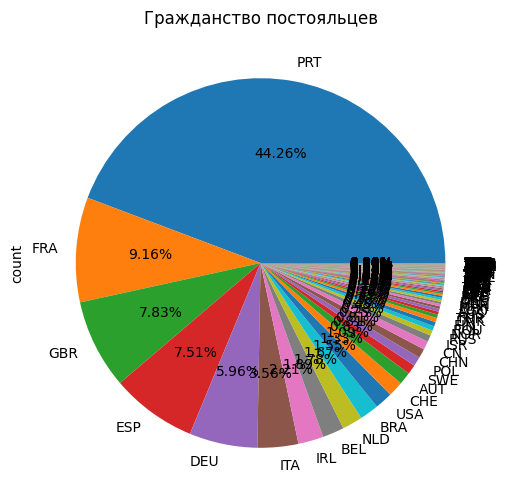

In [164]:
df1['country'].value_counts().plot.pie(legend=False, autopct='%1.2f%%', figsize=(12,6))
plt.title('Гражданство постояльцев')
plt.show()

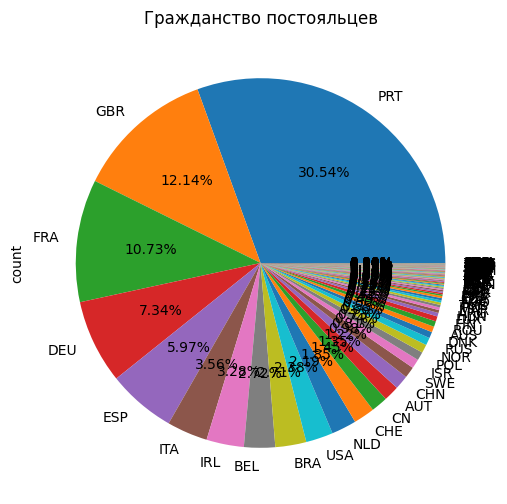

In [165]:
df2['country'].value_counts().plot.pie(legend=False, autopct='%1.2f%%', figsize=(12,6))
plt.title('Гражданство постояльцев')
plt.show()

**Все в норме.** Португальцы лидируют. Таблица названий и кодов стран мира https://www.artlebedev.ru/country-list/

In [166]:
vc1 = df1['country'].value_counts()
df1.loc[df1['country'].isin(vc1[vc1 < 64].index), 'country'] = 'other'

In [167]:
print (df1['country'].unique())

['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'other' 'CZE' 'ITA' 'FIN' 'DNK' 'LUX'
 'BRA' 'CHN' 'MAR' 'AUT' 'TUR' 'ISR' 'IND' 'AUS' 'KOR' 'HUN' 'JPN' 'SRB'
 'AGO']


In [168]:
vc2 = df2['country'].value_counts()
df2.loc[df2['country'].isin(vc2[vc2 < 64].index), 'country'] = 'other'

In [169]:
print (df2['country'].unique())

['PRT' 'AUT' 'BEL' 'DEU' 'BRA' 'GBR' 'ESP' 'FRA' 'ITA' 'LUX' 'CHE' 'other'
 'IRL' 'CN' 'POL' 'AUS' 'NLD' 'ROU' 'USA' 'DNK' 'FIN' 'RUS' 'SWE' 'HUN'
 'ISR' 'NOR' 'CHN' 'MAR' 'TUR' 'ARG' 'JPN']


***Проверим customer_type - тип заказчика***

In [170]:
print(df1['customer_type'].unique())
print(df2['customer_type'].unique())

['Transient' 'Contract' 'Transient-Party' 'Group']
['Transient' 'Transient-Party' 'Contract' 'Group']


In [171]:
print (df1['customer_type'].value_counts())
print (df2['customer_type'].value_counts())

customer_type
Transient          45387
Transient-Party    16623
Contract            2745
Group                286
Name: count, dtype: int64
customer_type
Transient          27394
Transient-Party     4415
Contract             359
Group                165
Name: count, dtype: int64


**Все в норме.** Категория "не связано с договором или групповым заездом" больше всех.

***Проверим days_in_waiting_list - сколько дней заказ ожидал подтверждения***

In [172]:
print(df1['days_in_waiting_list'].unique())
print(df2['days_in_waiting_list'].unique())

[  0  50  47  65 122  75 101 150 125  22 142   2  13  44  38  48  33  77
  21  80  59  40  58  89  53  49  60  69  87  91  57  99 111  79  98  85
  63  15   3  20  93   4  41  34 224  31  39  56 187 176  71  55  96 236
 259 207 215 160 120  30  32  27  62  24 108 147   5  14 107  70   8  35
 178 174 162  68  11 193  10  76  17  45   6  19  28  42  25  46   9   1
  43  72  12  61  81  74 167]
[  0  14  60 100 121  61   5   1 107  43 122  83   4 113  18  20 185  93
 109  34   6  13   8 154  64  99  76  16  22  28  21   9 165   2  44  17
  53  38  50 111  25  46   7  47  27  49  84  30 175 183  39  56  31  10
  15  23  63  33  32  11  35 117  57  12  80  71  54  59  26  73 223 105
  65  36  98]


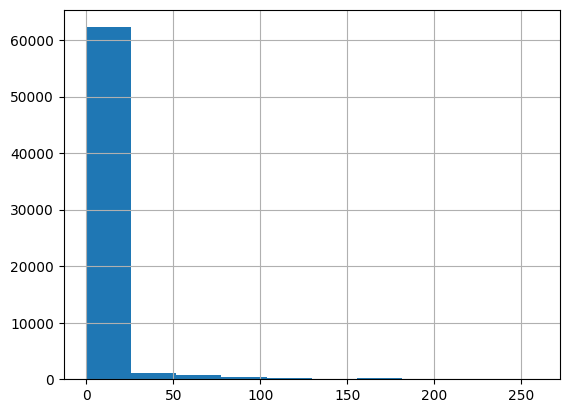

In [173]:
df1['days_in_waiting_list'].hist(bins=10)
plt.show()

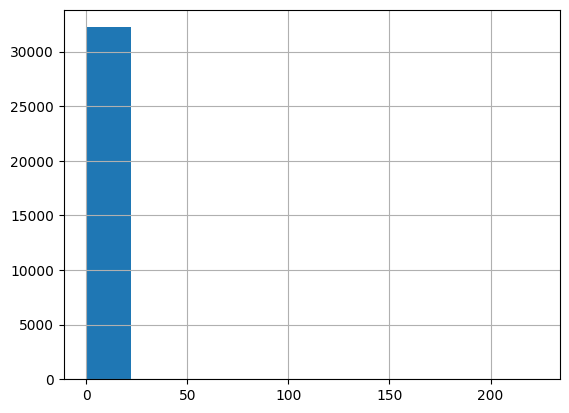

In [174]:
df2['days_in_waiting_list'].hist(bins=10)
plt.show()

In [175]:
len(df1.query('days_in_waiting_list > 250'))

10

**Все в норме.** Я не считаю в данном случае есть выбросы

***Проверим distribution_channel - канал дистрибуции заказа***

In [176]:
print(df1['distribution_channel'].unique())
print(df2['distribution_channel'].unique())

['Direct' 'TA/TO' 'Corporate' 'GDS']
['TA/TO' 'Direct' 'Corporate' 'GDS']


In [177]:
print (df1['distribution_channel'].value_counts())
print (df2['distribution_channel'].value_counts())

distribution_channel
TA/TO        54291
Direct        6830
Corporate     3821
GDS             99
Name: count, dtype: int64
distribution_channel
TA/TO        27015
Direct        3632
Corporate     1601
GDS             85
Name: count, dtype: int64


**Все в норме.**

***Проверим is_canceled — отмена заказа***

In [178]:
print(df1['is_canceled'].unique())
print(df2['is_canceled'].unique())

[0 1]
[1 0]


In [179]:
print (df1['is_canceled'].value_counts())
print (df2['is_canceled'].value_counts())

is_canceled
0    41049
1    23992
Name: count, dtype: int64
is_canceled
0    19773
1    12560
Name: count, dtype: int64


**Все в норме.**

***Проверим meal - опции заказа***

In [180]:
print(df1['meal'].unique())
print(df2['meal'].unique())

['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']
['BB       ' 'HB       ' 'SC' 'FB       ' 'SC       ']


In [181]:
print(df1['meal'].value_counts())
print(df2['meal'].value_counts())

meal
BB           51528
HB            7285
SC            5262
SC             515
FB             451
Name: count, dtype: int64
meal
BB           24615
SC            5027
HB            2397
SC             258
FB              36
Name: count, dtype: int64


**Некорретное написание!**

In [182]:
# исправляем
df1['meal'] = df1['meal'].str.strip()
df2['meal'] = df2['meal'].str.strip()

In [183]:
# проверяем
print(df1['meal'].unique())
print(df2['meal'].unique())

['BB' 'FB' 'HB' 'SC']
['BB' 'HB' 'SC' 'FB']


In [184]:
print(df1['meal'].value_counts())
print(df2['meal'].value_counts())

meal
BB    51528
HB     7285
SC     5777
FB      451
Name: count, dtype: int64
meal
BB    24615
SC     5285
HB     2397
FB       36
Name: count, dtype: int64


Я могу конечно ошибаться, но Nan не существует - это глюк.

**Все в норме.**

***Проверим previous_bookings_not_canceled — количество подтверждённых заказов у клиента***

In [185]:
print(df1['previous_bookings_not_canceled'].unique())
print(df2['previous_bookings_not_canceled'].unique())

[ 0  1  2  3  4  5  6 10 12 13 15 21  7  9  8 11 14 18 22 16 17 19 20 23
 24 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 47 48 49
 50 51 52 53 54 55 56 57 58 25]
[ 0  3  2  5  6  7  8 10 11 12  4  1  9 25 27 28 30 13 14 23 24 26 16 15
 17 18 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 19 29 20 21 22]


In [186]:
# Проверил количество значений value_counts() и подобрал что 30 это норма
# исправляем
df1.drop(df1[df1['previous_bookings_not_canceled'] > 30].index, inplace=True)
df2.drop(df2[df2['previous_bookings_not_canceled'] > 30].index, inplace=True)

In [187]:
# проверим
print(df1['previous_bookings_not_canceled'].unique())
print(df2['previous_bookings_not_canceled'].unique())

[ 0  1  2  3  4  5  6 10 12 13 15 21  7  9  8 11 14 18 22 16 17 19 20 23
 24 26 27 28 29 30 25]
[ 0  3  2  5  6  7  8 10 11 12  4  1  9 25 27 28 30 13 14 23 24 26 16 15
 17 18 19 29 20 21 22]


**Все в норме.**

***Проверим previous_cancellations - количество отменённых заказов у клиента***

In [188]:
print (df1['previous_cancellations'].unique())
print (df2['previous_cancellations'].unique())

[ 0  1  2  3 26 25 14 24 19  4  5 21 13 11  6]
[0 1 2 3 4 5]


In [189]:
print (df1['previous_cancellations'].value_counts())
print (df2['previous_cancellations'].value_counts())

previous_cancellations
0     59404
1      5366
2        54
3        37
11       35
24       28
25       19
26       18
19       17
13       12
14       11
6         6
4         2
5         2
21        1
Name: count, dtype: int64
previous_cancellations
0    32108
1      164
2       29
4       10
3        6
5        1
Name: count, dtype: int64


In [190]:
# исправляем. Убираем выброс.
df1.drop(df1[df1['previous_cancellations'] > 5].index, inplace=True)

In [191]:
# проверим
print (df1['previous_cancellations'].unique())
print (df2['previous_cancellations'].unique())

[0 1 2 3 4 5]
[0 1 2 3 4 5]


**Все в норме.** 


***Проверим required_car_parking_spaces — необходимость места для автомобиля***

In [192]:
print(df1['required_car_parking_spaces'].unique())
print(df2['required_car_parking_spaces'].unique())

[0 1 2 3]
[0 1 2 8 3]


In [193]:
print (df1['required_car_parking_spaces'].value_counts())
print (df2['required_car_parking_spaces'].value_counts())

required_car_parking_spaces
0    61195
1     3658
2       11
3        1
Name: count, dtype: int64
required_car_parking_spaces
0    30845
1     1464
2        6
8        2
3        1
Name: count, dtype: int64


In [194]:
# 8 тут явно лишняя 
# исправляем
df2.drop(df2[df2['required_car_parking_spaces'] > 3].index, inplace=True)

In [195]:
# проверим
print(df1['required_car_parking_spaces'].unique())
print(df2['required_car_parking_spaces'].unique())

[0 1 2 3]
[0 1 2 3]


**Все в норме.**

In [196]:
print (df1['required_car_parking_spaces'].value_counts())
print (df2['required_car_parking_spaces'].value_counts())

required_car_parking_spaces
0    61195
1     3658
2       11
3        1
Name: count, dtype: int64
required_car_parking_spaces
0    30845
1     1464
2        6
3        1
Name: count, dtype: int64


In [197]:
# исправляем
df1.drop(df1[df1['required_car_parking_spaces'] > 1].index, inplace=True)
df2.drop(df2[df2['required_car_parking_spaces'] > 1].index, inplace=True)

In [198]:
print (df1['required_car_parking_spaces'].value_counts())
print (df2['required_car_parking_spaces'].value_counts())

required_car_parking_spaces
0    61195
1     3658
Name: count, dtype: int64
required_car_parking_spaces
0    30845
1     1464
Name: count, dtype: int64


***Проверим reserved_room_type - тип забронированной комнаты***

In [199]:
print (df1['reserved_room_type'].unique())
print (df2['reserved_room_type'].unique())

['A               ' 'C               ' 'D               '
 'E               ' 'G               ' 'F               '
 'B               ']
['A               ' 'E               ' 'G               '
 'D               ' 'F               ' 'C               '
 'B               ']


In [200]:
print (df1['reserved_room_type'].value_counts())
print (df2['reserved_room_type'].value_counts())

reserved_room_type
A                   50298
D                    9371
E                    2442
F                    1209
B                     714
G                     592
C                     227
Name: count, dtype: int64
reserved_room_type
A                   23434
D                    6121
E                    1640
F                     503
G                     275
C                     200
B                     136
Name: count, dtype: int64


**Некорретное написание!**

In [201]:
# исправляем
df1['reserved_room_type'] = df1['reserved_room_type'].str.strip()
df2['reserved_room_type'] = df2['reserved_room_type'].str.strip()

In [202]:
# проверяем
print(df1['reserved_room_type'].unique())
print(df2['reserved_room_type'].unique())

['A' 'C' 'D' 'E' 'G' 'F' 'B']
['A' 'E' 'G' 'D' 'F' 'C' 'B']


**Все в норме.**

***Проверим stays_in_weekend_nights — количество ночей в выходные дни***

In [203]:
print (df1['stays_in_weekend_nights'].unique())
print (df2['stays_in_weekend_nights'].unique())

[0 2 1 4 3]
[1 2 0 4 3]


In [204]:
print (df1['stays_in_weekend_nights'].value_counts())
print (df2['stays_in_weekend_nights'].value_counts())

stays_in_weekend_nights
0    29593
1    17610
2    17239
3      259
4      152
Name: count, dtype: int64
stays_in_weekend_nights
0    13869
2     9187
1     9082
3      101
4       70
Name: count, dtype: int64


**Все в норме.**

***Проверим stays_in_week_nights — количество ночей в будние дни***

In [205]:
print (df1['stays_in_week_nights'].unique())
print (df2['stays_in_week_nights'].unique())

[1 2 3 4 5 6 0]
[0 2 5 1 3 4 6]


In [206]:
print (df1['stays_in_week_nights'].value_counts())
print (df2['stays_in_week_nights'].value_counts())

stays_in_week_nights
2    20052
1    17767
3    12241
4     5104
5     5078
0     3978
6      633
Name: count, dtype: int64
stays_in_week_nights
2    8978
1    8019
3    7299
4    2961
5    2860
0    1933
6     259
Name: count, dtype: int64


**Все в норме.**

***Проверим total_nights — общее количество ночей***

In [207]:
print (df1['total_nights'].unique())
print (df2['total_nights'].unique())

[ 1  2  3  4  6  7  5  8 10  9]
[ 1  4  7  2  5  6  3  8  9 10]


In [208]:
print (df1['total_nights'].value_counts())
print (df2['total_nights'].value_counts())

total_nights
2     16700
3     15559
1     12080
4      9569
5      4264
7      3827
6      2045
8       540
9       151
10      118
Name: count, dtype: int64
total_nights
3     8365
2     6750
4     5800
1     5451
5     2402
7     2279
6      934
8      211
9       62
10      55
Name: count, dtype: int64


**Все в норме.**

***Проверим total_of_special_requests — количество специальных отметок***

In [209]:
print (df1['total_of_special_requests'].unique())
print (df2['total_of_special_requests'].unique())

[0 1 3 2 4 5]
[0 1 2 3 4 5]


In [210]:
print (df1['total_of_special_requests'].value_counts())
print (df2['total_of_special_requests'].value_counts())

total_of_special_requests
0    40455
1    16852
2     6402
3     1027
4      105
5       12
Name: count, dtype: int64
total_of_special_requests
0    17312
1     9997
2     3959
3      899
4      124
5       18
Name: count, dtype: int64


**Все в норме.**

***Проверим такое бронирование при котором заселились только дети без взрослых***

In [211]:
print (df1.query('(children > 0 | babies > 0) & adults == 0').shape[0])
print (df2.query('(children > 0 | babies > 0) & adults == 0').shape[0])

0
0


In [212]:
# удалим их
df1.drop(df1.query('(children > 0 | babies > 0) & adults == 0').index, inplace=True)
df2.drop(df2.query('(children > 0 | babies > 0) & adults == 0').index, inplace=True)

In [213]:
# проверим 
print (df1.query('(children > 0 | babies > 0) & adults == 0').shape[0])
print (df2.query('(children > 0 | babies > 0) & adults == 0').shape[0])

0
0


***Проверим заселения номера без постояльцев***

In [214]:
print (df1.query('adults == 0').shape[0])
print (df2.query('adults == 0').shape[0])

0
0


In [215]:
# удалим их
df1.drop(df1.query('adults == 0').index, inplace=True)
df2.drop(df2.query('adults == 0').index, inplace=True)

In [216]:
# проверим 
print (df1.query('adults == 0').shape[0])
print (df2.query('adults == 0').shape[0])

0
0


***Отказ от брони или отмена заказа "is_canceled" наш целевой признак. Изучим его более подробно.***

In [217]:
# какие значения имеем
print(df1['is_canceled'].unique())
print (df2['is_canceled'].unique())

[0 1]
[1 0]


In [218]:
# что с балансом?
print (df1['is_canceled'].value_counts())
print (df2['is_canceled'].value_counts())

is_canceled
0    40985
1    23868
Name: count, dtype: int64
is_canceled
0    19749
1    12560
Name: count, dtype: int64


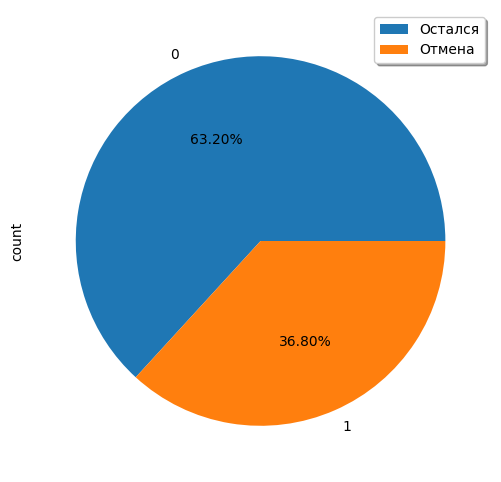

In [219]:
df1['is_canceled'].value_counts().plot.pie(legend=True, autopct='%1.2f%%', figsize=(12,6))
plt.legend(['Остался', 'Отмена'], shadow=True)
plt.show()

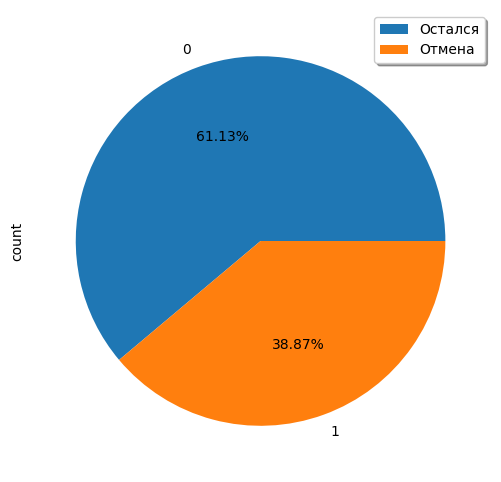

In [220]:
df2['is_canceled'].value_counts().plot.pie(legend=False, autopct='%1.2f%%', figsize=(12,6))
plt.legend(['Остался', 'Отмена'], shadow=True)
plt.show()

Не большой дисбаланс целевого признака есть, хотя он не является критичным. В моделях необходимо применить гиперпараметр class_weight='balanced' (Увеличиваем вес объектов редкого класса "1").

Посмотрим как это значение коррелирует со стольными

In [221]:
correlation_matrix_df1 = df1.select_dtypes(include=[np.number]).corr()

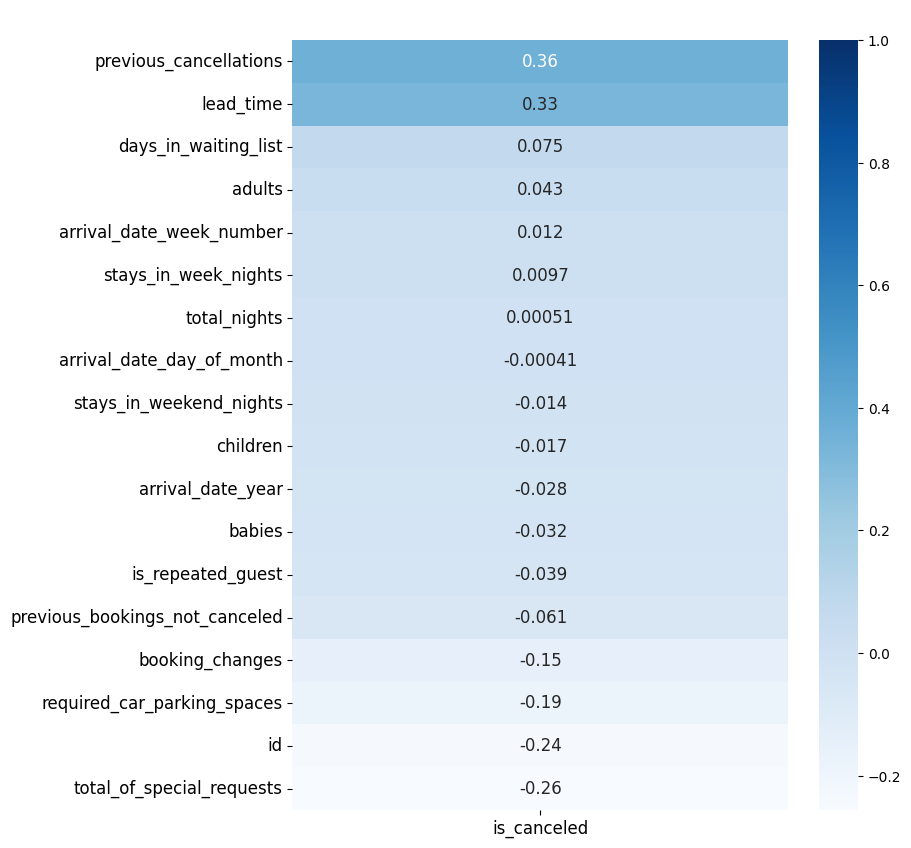

In [222]:
fig = plt.figure(figsize=(8,10))
ax = sns.heatmap(correlation_matrix_df1[['is_canceled']].sort_values('is_canceled', ascending=False), annot=True, annot_kws={"size":12}, cmap='Blues')
ax.tick_params(axis="both", labelsize=12)
y_min, y_max = ax.get_ylim()
ax.set_ylim(top=y_max+1)
plt.show()

Показатели с наибольшей корреляцией: 

•	lead_time — количество дней между датой бронирования и датой прибытия;

•	previous_cancellations — количество отменённых заказов у клиента.

In [223]:
correlation_matrix_df2 = df2.select_dtypes(include=[np.number]).corr()

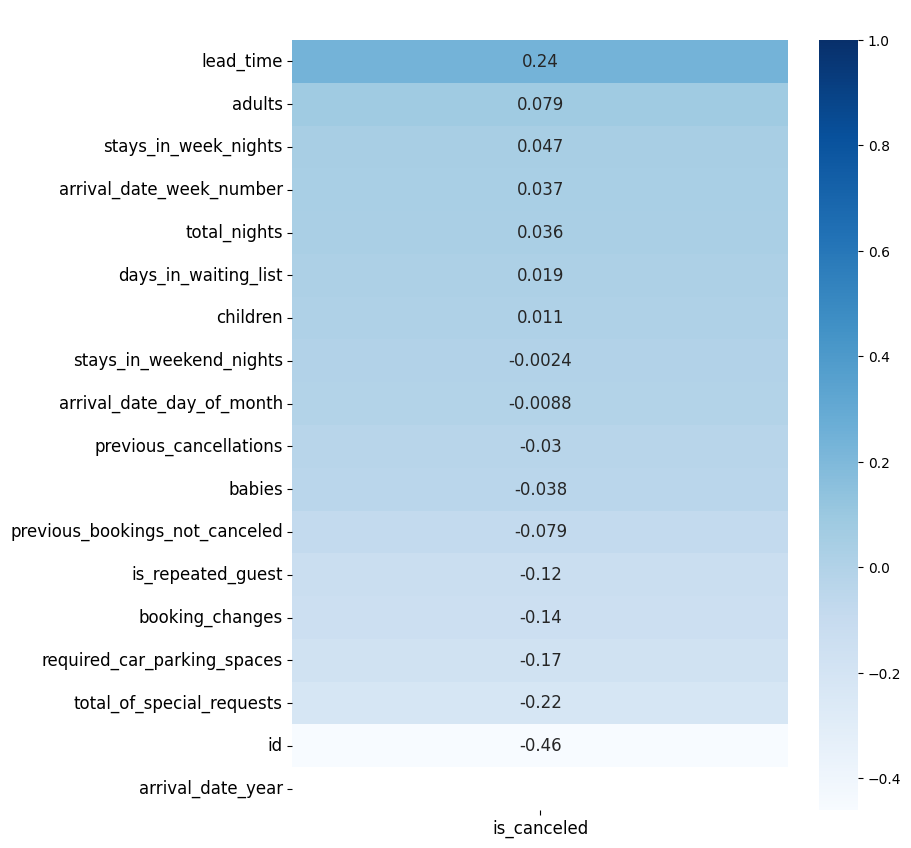

In [224]:
fig = plt.figure(figsize=(8,10))
ax = sns.heatmap(correlation_matrix_df2[['is_canceled']].sort_values('is_canceled', ascending=False), annot=True, annot_kws={"size":12}, cmap='Blues')
ax.tick_params(axis="both", labelsize=12)
y_min, y_max = ax.get_ylim()
ax.set_ylim(top=y_max+1)
plt.show()

Показатели не имеют явно выраженную взаимосвязь с кем то

Посмотрим на графике бронирований и отмены во времени

In [225]:
# создаем отдельную колонку в df1 объединяющую день, месяц и год.
df1['arrival_date_full'] = df1['arrival_date_year'].astype(str) + "-" + df1['arrival_date_month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}).astype(str) + "-" + df1['arrival_date_day_of_month'].astype(str)
df1['arrival_date_full'] = pd.to_datetime(df1['arrival_date_full'], format="%Y-%m-%d")

In [226]:
# cоздадим датафрейм данных отмененных
canceled = df1[df1['is_canceled']==1][['arrival_date_full']]
canceled.set_index('arrival_date_full', inplace=True)
canceled['count'] = 1
canceled=canceled.resample('M').sum()

In [227]:
# cоздадим датафрейм данных не отмененных бронирований
not_canceled = df1[df1['is_canceled']==0][['arrival_date_full']]
not_canceled.set_index('arrival_date_full', inplace=True)
not_canceled['count'] = 1
not_canceled=not_canceled.resample('M').sum()

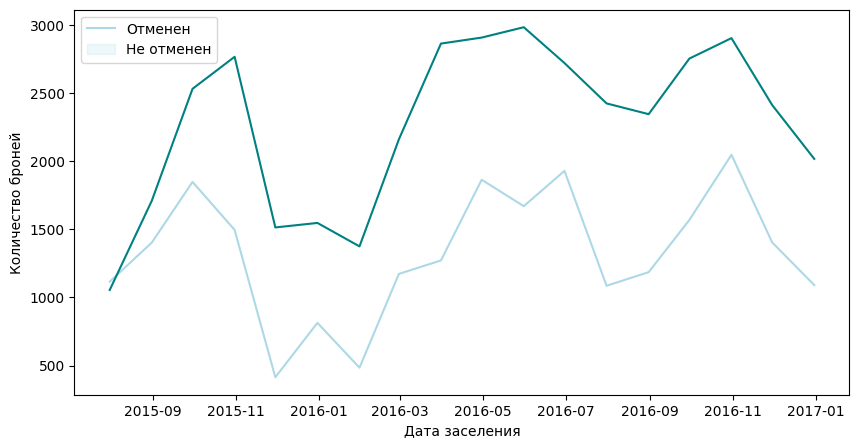

In [228]:
plt.figure(figsize=(10,5))
sns.lineplot(x=canceled.index, y=canceled['count'], color='lightblue')
sns.lineplot(x=not_canceled.index, y=not_canceled['count'], color='teal')
plt.ylabel('Количество броней')
plt.xlabel('Дата заселения')
plt.legend(['Отменен', 'Не отменен']);
plt.show()

ВЫВОДЫ: По всей видимости мы можем наблюдать общий экономический тренд в этих годах. Если бы были данные хотя бы за 5 лет, я бы мог выявить сезонность изменений. 

Посмотрим процент отмененных бронирований для каждого забронированного типа номеров

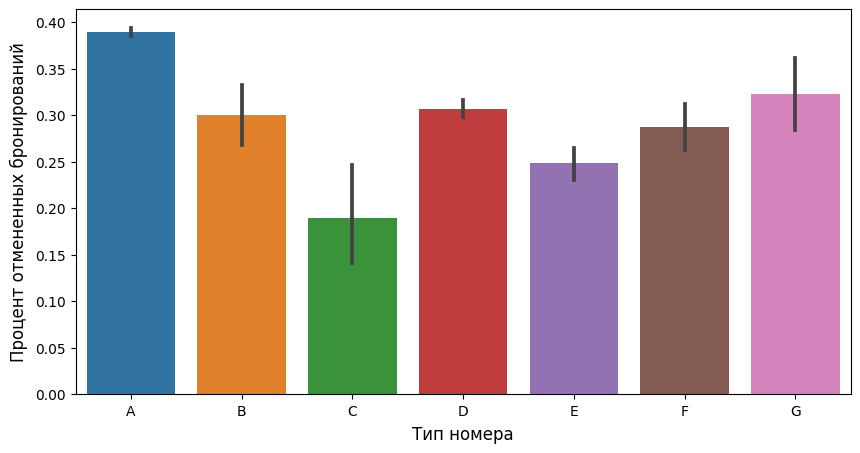

In [229]:
plt.figure(figsize=(10,5)) 
sns.barplot(data = df1, x='reserved_room_type', y='is_canceled', order = ['A','B','C','D','E','F','G'])
plt.xlabel("Тип номера", fontsize = 12, labelpad = 5)
plt.ylabel("Процент отмененных бронирований", fontsize = 12, labelpad = 5);
plt.show()

ВЫВОДЫ: Чаще всего отмена брони была у номеров типа "А". Меньше всего отмены было у номеров типа "С". Остальные типы номеров, по отмене находятся в средних значениях. У меня нет четкого понимания как разделяются типы номеров по комфорту. Однозначных выводом сделать не могу.

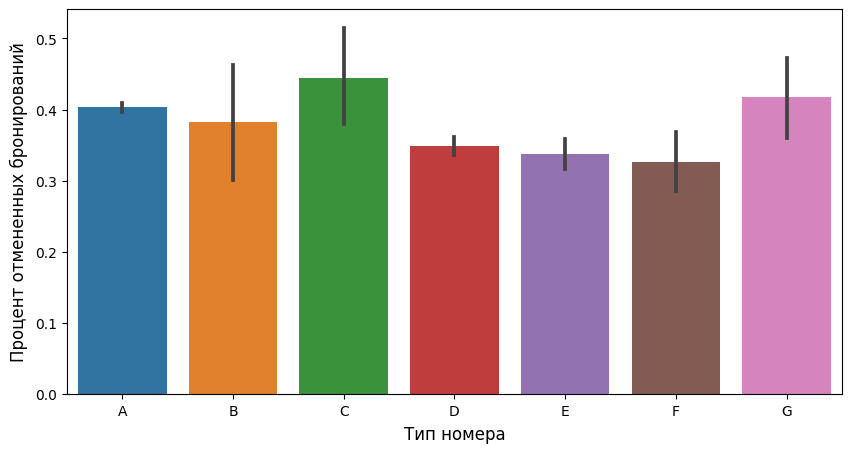

In [230]:
plt.figure(figsize=(10,5)) 
sns.barplot(data = df2, x='reserved_room_type', y='is_canceled', order = ['A','B','C','D','E','F','G'])
plt.xlabel("Тип номера", fontsize = 12, labelpad = 5)
plt.ylabel("Процент отмененных бронирований", fontsize = 12, labelpad = 5);
plt.show()

ВЫВОДЫ: Чаще всего отмена брони была у номеров типа "С". Меньше всего отмены было у номеров типа "F". Остальные типы номеров, по отмене находятся в средних значениях. У меня нет четкого понимания, как разделяются типы номеров по комфорту. Однозначных выводом сделать не могу.

<div class="alert alert-info" style="border-color: pink; border-radius: 5px">
    <p><u><b> ВЫВОДЫ ПО РАЗДЕЛУ 2:</b></u></p>
    <p>В данном раздели я провел предобработку (убрал выбросы, неявные дубликаты, лишние пропуски) и исследовательский анализ данных. Так же в конце я провел анализ значений "отмена заказа" (is_canceled) так, как в дальнейшем он будет целевым признаком</p>
</div>

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Оценим прибыль отеля без внедрения депозитов.

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:

•	категория A: за ночь — 1 000, разовое обслуживание — 400;

•	категория B: за ночь — 800, разовое обслуживание — 350;

•	категория C: за ночь — 600, разовое обслуживание — 350;

•	категория D: за ночь — 550, разовое обслуживание — 150;

•	категория E: за ночь — 500, разовое обслуживание — 150;

•	категория F: за ночь — 450, разовое обслуживание — 150;

•	категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.


In [231]:
# cтоимость номеров отеля
columns = ['reserved_room_type' , 'room_price', 'room_service']
data = [['A', 1000, 400],['B', 800, 350], ['C', 600, 350], ['D', 550, 150], 
        ['E', 500, 150], ['F', 450, 150], ['G', 350, 150]]
room_cost = pd.DataFrame(data=data, columns=columns)

In [232]:
# проверим
room_cost.head(7)

,reserved_room_type,room_price,room_service
0,A,1000,400
1,B,800,350
2,C,600,350
3,D,550,150
4,E,500,150
5,F,450,150
6,G,350,150


In [233]:
# сезонные коэффициенты
seasonal_coef = pd.DataFrame({'arrival_date_month': ['January', 'February', 'March', 'April', 'May', 'June', 
                                    'July', 'August', 'September','October', 'November', 'December'], 
                            'coef': [1.0, 1.0, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4, 1.2, 1.2, 1.2, 1.0]})

In [234]:
# проверим
seasonal_coef.head(12)

,arrival_date_month,coef
0,January,1.000
1,February,1.000
2,March,1.200
3,April,1.200
4,May,1.200
5,June,1.400
6,July,1.400
7,August,1.400
8,September,1.200
9,October,1.200


In [235]:
# df2.columns посмотрим
# создадим отдельную таблицу для подсчета прибыли
profit_table = df2.drop(columns = ['id', 'lead_time', 'arrival_date_week_number', 
                                   'arrival_date_day_of_month', 'stays_in_weekend_nights',
                                   'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 
                                   'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 
                                   'previous_bookings_not_canceled', 'booking_changes', 
                                   'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces',
                                   'total_of_special_requests'],axis=1)

In [236]:
profit_table.head(5)

,is_canceled,arrival_date_year,arrival_date_month,reserved_room_type,total_nights
0,1,2017,January,A,1
1,1,2017,January,A,4
2,1,2017,January,A,4
3,1,2017,January,A,4
4,1,2017,January,A,7


In [237]:
# соединим таблицы
profit_table_1 = profit_table.merge(room_cost, on='reserved_room_type', how='inner')

In [238]:
# проверим
profit_table_1.head(5)

,is_canceled,arrival_date_year,arrival_date_month,reserved_room_type,total_nights,room_price,room_service
0,1,2017,January,A,1,1000,400
1,1,2017,January,A,4,1000,400
2,1,2017,January,A,4,1000,400
3,1,2017,January,A,4,1000,400
4,1,2017,January,A,7,1000,400


In [239]:
profit_table_1.shape

(32309, 7)

In [240]:
profit_table_2 = profit_table_1.merge(seasonal_coef, on='arrival_date_month', how='inner')

In [241]:
# проверим
profit_table_2.head(5)

,is_canceled,arrival_date_year,arrival_date_month,reserved_room_type,total_nights,room_price,room_service,coef
0,1,2017,January,A,1,1000,400,1.000
1,1,2017,January,A,4,1000,400,1.000
2,1,2017,January,A,4,1000,400,1.000
3,1,2017,January,A,4,1000,400,1.000
4,1,2017,January,A,7,1000,400,1.000


In [242]:
profit_table_2.shape

(32309, 8)

In [243]:
# на основании данных из таблицы profit_table найдем прибыль
# функция расчета прибыли
def profit(row):
    if row['is_canceled']==0:   # если нет отмены 
        # доход = cтоимость номера (умнож) на общее количество ночей и (умнож) на сезонный коэффициент
        income = row['room_price']*row['total_nights']*row['coef']
        # при этом есть расходы на обслуживание номера
        # Если клиент снял номер надолго, то убираются каждые два дня
        expenses = row['room_service']*round(1 + row['total_nights']//2)
    else: # иначе, если отмена есть
        income=0 # отель не имеет дохода
        # Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента 
        #expenses = сезонный коэффициент * стоимость номера за ночь + стоимость одной уборки
        expenses = row['coef']*row['room_price']+row['room_service']        
    profit = income - expenses
    return profit

In [244]:
profit_table_2['total_profit'] = profit_table_2.apply(profit, axis=1)

In [245]:
profit_table_2.head()

,is_canceled,arrival_date_year,arrival_date_month,reserved_room_type,total_nights,room_price,room_service,coef,total_profit
0,1,2017,January,A,1,1000,400,1.000,-1400.000
1,1,2017,January,A,4,1000,400,1.000,-1400.000
2,1,2017,January,A,4,1000,400,1.000,-1400.000
3,1,2017,January,A,4,1000,400,1.000,-1400.000
4,1,2017,January,A,7,1000,400,1.000,-1400.000


In [246]:
print('Прибыль отеля без внедрения депозита составляет: {:.2f} млн.рублей'
      .format((profit_table_2['total_profit'].sum()) / 1000000))

Прибыль отеля без внедрения депозита составляет: 32.43 млн.рублей


Средние значения по годам.

In [247]:
pd.concat([profit_table_2]).pivot_table(values='total_profit', index='arrival_date_year', aggfunc=['count', 'sum', 'mean'])

,count,sum,mean
,total_profit,total_profit,total_profit
arrival_date_year,,,
2017,32309,32429120.000,1003.718


<div class="alert alert-info" style="border-color: pink; border-radius: 5px">
    <p><u><b> ВЫВОДЫ ПО РАЗДЕЛУ 3:</b></u></p>
    <p>В данном раздели я не используя ML посчитал прибыль отеля c января по август 2017 года без внедрения депозита. </p>
</div>

### Шаг 4. Разработка модели ML

In [248]:
df1.head(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_full
0,0,0,7.000,2015,July,27,1,0,1,1.000,0.000,0.000,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1,2015-07-01
1,1,0,14.000,2015,July,27,1,0,2,2.000,0.000,0.000,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2,2015-07-01
2,2,0,0.000,2015,July,27,1,0,2,2.000,0.000,0.000,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2,2015-07-01
3,3,0,9.000,2015,July,27,1,0,2,2.000,0.000,0.000,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2,2015-07-01
4,4,1,85.000,2015,July,27,1,0,3,2.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3,2015-07-01


Целевой признак - это колонка 'is_canceled'. Уберем не значимые данные, а так же данные которые могут помешать ML.

Признаки. При проведении анализа нами было выявлена сильная корреляция между значениями: 

id "номер записи" - не несет никакой важной информации

total_nights "общее количество ночей" - между столбцами stays_in_weekend_nights "количество ночей в выходные дни" и total_nights "общее количество ночей" - 0.6 и между столбцами stays_in_week_nights "количество ночей в будние дни" и total_nights "общее количество ночей" - 0.83

arrival_date_year "год заезда" - не понадобится, так как в выборке прошедшие года, а модель предсказывает отмену в текущем

arrival_date_month "месяц заезда"  — у нас есть номер недели, что уже включает информацию о месяце

arrival_date_day_of_month "день заезда" — не несет никакой важной информации

distribution_channel "канал дистрибуции заказа" - отмена не зависит от компании направившей на отель

Так же удалим ранее созданную колонку arrival_date_full.

ПОДСКАЗКА: относительно id и временных признаков соглашусь, но остальные утверждения лучше аргументировать на данных:
    
1. Вполне может быть, что в некоторых каналах дистрибуции доля отмен выше, чем в других, тогда этот признак будет полезен и для моделей, и для анализа, ведь заказчику будет полезно узнать, что с какими-то каналами могут быть проблемы
2. Судя по описанию, `total_nights` — это действительно сумма `stays_in_week_nights` и `stays_in_weekend_nights`, но перед удалением нужно проверить, выполняется ли это условие для всех бронирований
3. Непонятно, куда пропал признак `booking_changes`

Есть небольшая проблема: наши данные содержат категориальные признаки. Все признаки должны стать количественными, поэтому нам подходит техника прямого кодирования, или отображения (англ. One-Hot Encoding, OHE).

In [249]:
columns_features = ['adults', 'arrival_date_week_number', 'babies', 'children', 'customer_type', 'country',
                    'days_in_waiting_list', 'is_repeated_guest', 'lead_time', 'meal', 'previous_bookings_not_canceled',
                   'previous_cancellations', 'required_car_parking_spaces', 'reserved_room_type',  'total_of_special_requests',
                    'is_canceled' ]
hotel_train_ohe = df1[columns_features]
hotel_test_ohe = df2[columns_features]

In [250]:
#целевой признак
target_train = hotel_train_ohe['is_canceled']
target_test = hotel_test_ohe['is_canceled']
#признаки
features_train = hotel_train_ohe.drop('is_canceled', axis=1)
features_test = hotel_test_ohe.drop('is_canceled', axis=1)

In [251]:
print(features_train.shape, features_test.shape)
print(target_train.shape, target_test.shape)

(64853, 15) (32309, 15)
(64853,) (32309,)


In [252]:
features_train.shape[0] / features_test.shape[0]

2.007273515119626

Проведем кодирование всех данных

In [253]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(features_train)
features_train = enc.transform(features_train) 
features_test = enc.transform(features_test)

**Основная цель нашей модели — максимизировать прибыль, путем минимизации убытков. В контексте модели это значит минимизировать количество ложноотрицательных ответов, то есть основная метрика для нас — это recall.**

Модель "Логистическая регрессия"

In [255]:
# определяем вид модели и ее гиперпараметры
model_lr = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

# обучаем модель на обучающем наборе данных
model_lr.fit(features_train, target_train)

# предсказания модели
prediction_lr = model_lr.predict(features_train)

print("Accuracy:    {:.4f}".format(model_lr.score(features_train, target_train)))
print("Recall:      {:.4f}".format(recall_score(target_train, prediction_lr)))
print("Precision:   {:.4f}".format(precision_score(target_train, prediction_lr)))
print("F1:          {:.4f}".format(f1_score(target_train, prediction_lr)))

probavilities_valid_lr = model_lr.predict_proba(features_train)
probavilities_one_valid_lr = probavilities_valid_lr[:,1]
print("ROC_auc:     {:.4f}".format(roc_auc_score(target_train, probavilities_one_valid_lr)))

print('')
score_lr = cross_val_score(model_lr, features_train, target_train, cv=5, scoring='recall').mean()
print('Кросс-валидация Recall:  {:.4f}'.format(score_lr))

Accuracy:    0.8192
Recall:      0.7983
Precision:   0.7338
F1:          0.7647
ROC_auc:     0.8987

Кросс-валидация Recall:  0.5763


Модель "Решающее дерево"

In [256]:
best_model2 = None
best_rezult2 = 0
for depth in range(1, 10):
    # определяем вид модели и ее гиперпараметры
    model_df = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    
    # обучаем модель на обучающем наборе данных
    model_df.fit(features_train, target_train)
    
    # предсказания модели
    prediction_df = model_df.predict(features_train)

    # находим F1-меру
    rezult2 = f1_score(target_train, prediction_df)
    
    if best_rezult2 < rezult2:
        best_rezult2 = rezult2
        max_depth2 = depth
        best_model2 = model_df
    
print("Accuracy:    {:.4f}".format(model_df.score(features_train, target_train)))
print("Recall:      {:.4f}".format(recall_score(target_train, prediction_df)))
print("Precision:   {:.4f}".format(precision_score(target_train, prediction_df)))
print("F1:          {:.4f}".format(best_rezult2), 'cо значением глубины =', max_depth2)    

probavilities_valid_df = model_df.predict_proba(features_train)
probavilities_one_valid_df = probavilities_valid_df[:,1]
print("ROC_auc:     {:.4f}".format(roc_auc_score(target_train, probavilities_one_valid_df)))

print('')
score_df = cross_val_score(model_df, features_train, target_train, cv=5, scoring='recall').mean()
print('Кросс-валидация Recall:  {:.4f}'.format(score_df))

Accuracy:    0.8010
Recall:      0.7804
Precision:   0.7086
F1:          0.7427 cо значением глубины = 9
ROC_auc:     0.8855

Кросс-валидация Recall:  0.6592


Модель "Случайный лес"*

In [257]:
best_model3 = None
best_rezult3 = 0
best_depth3 = 0
best_est3 = 0
for estimator in range(3, 9, 3):
    for depth in range(1, 10):
        # определяем вид модели и ее гиперпараметры
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=estimator, 
                                           max_depth = depth, class_weight='balanced')
    
        # обучаем модель на обучающем наборе данных
        model_rf.fit(features_train, target_train)
    
        # предсказания модели
        prediction_rf = model_rf.predict(features_train)
    
        # находим F1-меру
        rezult3 = f1_score(target_train, prediction_rf)
                
        if best_rezult3 < rezult3:
            best_model3 = model_rf
            best_rezult3 = rezult3
            best_depth3 = depth
            best_est3 = estimator

print("Accuracy:    {:.4f}".format(model_rf.score(features_train, target_train)))
print("Recall:      {:.4f}".format(recall_score(target_train, prediction_rf)))
print("Precision:   {:.4f}".format(precision_score(target_train, prediction_rf)))
print("F1:          {:.4f}".format(best_rezult3), 'cо значением глубины =', best_depth3, 'количество деревьев =', best_est3)    

probavilities_valid_rf = model_rf.predict_proba(features_train)
probavilities_one_valid_rf = probavilities_valid_rf[:,1]
print("ROC_auc:     {:.4f}".format(roc_auc_score(target_train, probavilities_one_valid_rf)))

print('')            
score_rf = cross_val_score(model_rf, features_train, target_train, cv=5, scoring='recall').mean() 
print('Кросс-валидация Recall:  {:.4f}'.format(score_rf))

Accuracy:    0.7880
Recall:      0.6548
Precision:   0.7392
F1:          0.6970 cо значением глубины = 7 количество деревьев = 6
ROC_auc:     0.8708

Кросс-валидация Recall:  0.5799


In [258]:
#Функция для сверки результатов
best_metrics = pd.DataFrame(data=[('Logistic Regression', model_lr.score(features_train, target_train), 
                                  recall_score(target_train, prediction_lr), 
                                  precision_score(target_train, prediction_lr),
                                  f1_score(target_train, prediction_lr),
                                  roc_auc_score(target_train, probavilities_one_valid_lr),
                                  score_lr),
                                  ('Decision Tree Classifier', model_df.score(features_train, target_train), 
                                  recall_score(target_train, prediction_df),
                                  precision_score(target_train, prediction_df),
                                  best_rezult2,
                                  roc_auc_score(target_train, probavilities_one_valid_df),
                                  score_df),
                                  ('Random Forest Classifier', model_rf.score(features_train, target_train), 
                                  recall_score(target_train, prediction_rf), 
                                  precision_score(target_train, prediction_rf),
                                  f1_score(target_train, prediction_rf),
                                  roc_auc_score(target_train, probavilities_one_valid_rf),
                                  score_rf)
                                 ],                                  
                                 columns=['Model', 'Accuracy', 'Recall', 'Precision','F1','ROC_auc', 'Кросс-валидация Recall'])
best_metrics

,Model,Accuracy,Recall,Precision,F1,ROC_auc,Кросс-валидация Recall
0,Logistic Regression,0.819,0.798,0.734,0.765,0.899,0.576
1,Decision Tree Classifier,0.801,0.780,0.709,0.743,0.886,0.659
2,Random Forest Classifier,0.788,0.655,0.739,0.694,0.871,0.580


**Метрики классификации**

Accuracy — доля правильных ответов алгоритма.

Recall (полнота) - полнота выявляет, какую долю положительных среди всех ответов выделила модель.

Precision (точность) - точность определяет, как много отрицательных ответов нашла модель, пока искала положительные.

F1-мера (англ. F1-score) - это среднее гармоническое полноты и точности.

AUC-ROC (от англ. Area Under Curve ROC, «площадь под ROC-кривой») - это как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой.

**Кросс-валидация** нужна, когда нужно сравнить модели, подобрать гиперпараметры или оценить полезность признаков. Она минимизирует случайность разделения данных и даёт более точный результат. Кросс-валидация строится на «скольжении» по блокам, каждый из которых поочередно становится валидационной выборкой.

***Основываясь на лучшей метрики кросс-валидации Recall со значением 0.659 выигрывает модель Decision Tree Classifier (cо значением глубины = 9)***

Теперь оценим прибыль, которую модель принесет за год.

In [259]:
model_best = DecisionTreeClassifier(random_state=12345, max_depth=9, class_weight='balanced')
    
# обучаем модель на обучающем наборе данных
model_best.fit(features_test, target_test)
 
# предсказания модели
predictions_best = model_best.predict(features_test)

Сохраним предсказания модели в таблице profit_table_2 в отдельном столбце 'predictions'

In [260]:
# проверим 
profit_table_2['predictions'] = predictions_best
display(profit_table_2.head())

,is_canceled,arrival_date_year,arrival_date_month,reserved_room_type,total_nights,room_price,room_service,coef,total_profit,predictions
0,1,2017,January,A,1,1000,400,1.000,-1400.000,1
1,1,2017,January,A,4,1000,400,1.000,-1400.000,0
2,1,2017,January,A,4,1000,400,1.000,-1400.000,0
3,1,2017,January,A,4,1000,400,1.000,-1400.000,1
4,1,2017,January,A,7,1000,400,1.000,-1400.000,1


In [261]:
def profit_pred(row, col):
    
    # is_canceled = 0, predictions = 0 — постоялец заселился (profit > 0), модель предсказала, что он заселится. 
    # В этом случае прибыль отеля никак не меняется.
    if row['is_canceled']==0 and row[col]==0:   
        # доход = cтоимость номера (умнож) на общее количество ночей и (умнож) на сезонный коэффициент
        income = row['room_price']*row['total_nights']*row['coef']
        # при этом есть расходы на обслуживание номера
        expenses = row['room_service']*round(1 + row['total_nights']//2)
    
    # is_canceled = 0, predictions = 1 — постоялец заселился (profit > 0), модель предсказала, что он отменит. 
    # В этом случае прибыль отеля тоже никак не меняется.    
    elif row['is_canceled']==0 and row[col]==1:
        # доход = cтоимость номера (умнож) на общее количество ночей и (умнож) на сезонный коэффициент
        income = row['room_price']*row['total_nights']*row['coef']
        # при этом есть расходы на обслуживание номера
        expenses = row['room_service']*round(1 + row['total_nights']//2)
      
    # is_canceled = 1, predictions = 0 — постоялец отменил бронь (profit < 0), модель предсказала, что он заселится, 
    # то есть депозит с такого клиента не брали. Тогда прибыль отеля тоже никак не меняется, отель просто потерял деньги, 
    # как и до внедрения модели.
    elif (row['is_canceled']==1) and (row[col]==0):
        income = 0
        expenses = row['coef']*row['room_price']+row['room_service']
    
    # s_canceled = 1, predictions = 1 — постоялец отменил бронь (profit < 0), модель предсказала, что он отменит, 
    # с постояльца взяли депозит в 80% от стоимости номера за одни сутки с учетом сезонного коэффициента и затрат 
    # на разовую уборку, отель потеряет только 20% от той суммы, которую терял без модели, так как остальное покроет депозит
    elif (row['is_canceled']==1) and (row[col]==1):
        #income= row['room_price']*0.8
        #deposit = 0.8 * (сезонный коэффициент * стоимость номера за одну ночь + стоимость одной уборки)
        income = 0.8*(row['coef']*row['room_price']+row['room_service'])     
        expenses = row['coef']*row['total_nights']+row['room_service']
    
    profit_pred = income - expenses
    return profit_pred

In [262]:
profit_table_2['total_profit'] = profit_table_2.apply(profit_pred, col='predictions', axis=1)

In [263]:
print('Прибыль отеля c внедрением депозита составляет: {:.2f} млн.рублей'
      .format((profit_table_2['total_profit'].sum()) / 1000000))

Прибыль отеля c внедрением депозита составляет: 44.47 млн.рублей


In [264]:
pd.concat([profit_table_2]).pivot_table(values='total_profit', index='arrival_date_year', aggfunc=['count', 'sum', 'mean'])

,count,sum,mean
,total_profit,total_profit,total_profit
arrival_date_year,,,
2017,32309,44468300.200,1376.344


Теперь подсчитаем чистую прибыль отеля после внедрением депозита с учетом затрат на стоимость разработки системы прогнозирования:

In [265]:
DEVELOPER = 0.4 # млн.рублей
# Прибыль отеля без внедрения депозита составляет: 32.43 млн.рублей
# Прибыль отеля c внедрением депозита составляет: 44.47 млн.рублей
# itog_profit = 44.47-32.43-0.4 = 11,64 млн.рублей

<div class="alert alert-info" style="border-color: pink; border-radius: 5px">
    <p><u><b> ВЫВОДЫ ПО РАЗДЕЛУ 4:</b></u></p>
    <p>В данном раздели я подготовил данные и нашел лучшую модель используя ML для подсчета прибыли отеля.</p>
    <p>Основываясь на метрике кросс-валидации Recall для выбора лучшей модели, победила "DecisionTreeClassifier". Её recall 0.659</p>
    <p> --------</p>
    <p>Отель до внедрения системы депозитов за 2017 год получил прибыль 32.43 млн. рублей.</p>
    <p>Отель при внедрении системы депозитов за 2017 год получил бы прибыль 44.47 млн. рублей.</p>
    <p>C учетом затрат на разработку системы депозитов, отель за год мог бы получить дополнительно 11,64 млн.рублей. </p>
    
</div>

### Шаг 5. Опишите портрет «ненадёжного» клиента

На основе исследовательского анализа данных необходимо описать клиента, склонного к отказу от брони.

In [266]:
df2.pivot_table(index= 'adults', values = ['is_canceled']).sort_values(by='is_canceled',ascending=False)

,is_canceled
adults,
4.000,0.556
2.000,0.410
3.000,0.408
1.000,0.299


Чем больше людей едет, тем больше верояность отказа

In [267]:
df2.pivot_table(index= 'meal', values = ['is_canceled']).sort_values(by='is_canceled',ascending=False)

,is_canceled
meal,
BB,0.395
FB,0.389
SC,0.386
HB,0.333


Если клиент не приобретает дополнительных опций (SC), то он вероятнее всего приедет

In [268]:
df2.pivot_table(index= 'children', values = ['is_canceled']).sort_values(by='is_canceled',ascending=False)

,is_canceled
children,
2.000,0.465
0.000,0.388
1.000,0.365
3.000,0.333


По детям неоднозначно. Видимо люди с большим количеством детей все-таки стараются заранее заказать и тем, самым более надежные в заказе.

In [269]:
df2.pivot_table(index= 'customer_type', values = ['is_canceled']).sort_values(by='is_canceled',ascending=False)

,is_canceled
customer_type,
Transient,0.430
Transient-Party,0.166
Contract,0.125
Group,0.048


Групповой заезд очень выгоден

In [270]:
df2.pivot_table(index= 'reserved_room_type', values = ['is_canceled']).sort_values(by='is_canceled',ascending=False)

,is_canceled
reserved_room_type,
C,0.445
G,0.418
A,0.403
B,0.382
D,0.348
E,0.337
F,0.326


Не самая дешевая категория F (за ночь — 450), но статистика вещь такая

In [271]:
df2.pivot_table(index= 'total_nights', values = ['is_canceled']).sort_values(by='is_canceled',ascending=False)

,is_canceled
total_nights,
3,0.458
2,0.424
8,0.417
4,0.391
5,0.383
6,0.378
7,0.366
10,0.345
9,0.290


В принципе все люди чаще всего бронируют на 1 сутки

### Шаг 6. Напишите общий вывод

<div class="alert alert-info" style="border-color: pink; border-radius: 5px">
    <p><u><b> ВЫВОДЫ ПО РАЗДЕЛУ 6:</b></u></p>
    <p>В данном раздели я подготовил данные и нашел лучшую модель используя ML для подсчета прибыли отеля.</p>
    <p>Лучшая модель "Лог. регрессия". Её F-мера 0.6583421219152077. Так же построили ROC-кривую лучшей модели. AUC-ROC = 0.817927839084943</p>
    <p> --------</p>
    <p>Рекомендации отелю: при введении системы депозитов и внедрении ML по контролю и выявлению «ненадёжного» клиента за пол года компания сможет увеличить прибыль на 2,87 млн.рублей</p>
    
</div>